# Pitanja/odgovori 

Vrsta istraživanja prema:

- svrsi: primijenjena istraživanja
	- zbog toga što se oslanjamo na teoriju radi stvaranja pratkičnog znanstvenog rada
	- U znanstevnom radu su korištene unaprijed poznate teorija o obradi signala, entropijama, čišćenju podataka, optimizaciji parametera i treniranja modela za predikciju. Konkretno, sudionici koji su vozili unutar simulacije su nosili kapicu sa elektrodama koja prikuplja EEG podatke za vrijeme vožnje. Iz prikupljenih podataka, zajedno sa tehnikama obrade podataka i strojnog učenja, proizašao je model koji može predviđati stanje vozača za vrijeme vožnje.
- izvoru informacija: Primarno istraživanje
	- u ovom znanstevnom radu podaci su prikupljeni iz prve ruke na način da je promatrano 12 ispitanika u kontroliranim uvjetima. Za svakog ispitanika prikupljena su dva EEG signala
- vremenu provedbe: longitudinalno istraživanje
	- bitno je napomenuti da iako je istraživanje longitudinalno ono nema klasične karakteristike longitudinalnog istraživanja u smislu da traje više godina
	- longitudinalno je zbog toga što postoji više točaka u vremenu kad se provodi mjerenje stanja svakog ispitanika. Prvo su prikupljeni podaci za "normalno" stanje vožnje a zatim stanje "umora". Uzorak podataka za oba stanja vožnje je isti, tj. mjerenje je provedeno na istim ispitanicima za oba stanja
	- ne postoji problem sa nedostajućim podacima zbog malog vremenskog intervala između dva promatranja. Iz perspektive ispitanika mjeranja su vrlo vjerojatno obavljena u jednom danu i nije se dogodilo da je jedan sudionik odustao/nije bio prustan na nekom od dva mjerenja, što je često slučaj sa istraživanjima koja se protežu na više godina i puno sudionika  
- načinu prikupljanja: Laboratorijsko istraživanje
	- "u kontroliranom okruženju kako bi se znanstvenim metodama izolirala ovisna varijabla i uspostavio njezin odnos s drugim varijablama"
	- Kontrolirano okruženje u kontekstu ovog istraživačkog rada provedeno je u prostoru koji se sadrži kapicu s elektrodama, uređaj za vožnju i software za simulaciju. Podaci su za svakog sudionika prikupljani u sličnim vremenskim intervalima a za stanje "umora" su postavljene određena ograničenja koja prekidaju prikupljanje podataka 
- vrsti korištenja podataka: Kvantitativno istraživanje
	- znanstveni rad prikuplja kvantitativne podatake (EEG signali vozača) i koristi računalne alate (kapica sa elektrodama i software za simulaciju vožnje) za mjenje
- stupnju manipulacija varijablama: Eksperimentalno istraživanje
	- istraživanje je provedeno u kontroliranim uvjetima gdje je izmjenjena jedna varijabla prilikom dva mjeranja EEG signala. Ta varijabla je broj minuta koje su vozači morali voziti za vrijeme dva mjeranja.
		- U prvom mjerenju vozači su morali voziti 20 minuta, čime je osigurano da voze u normalnom stanju (tj. a *nisu umorni*)
		- U drugom mjerenju vozači su morali voziti 40 do 100 minuta čime je osigurano da voze u stanju manjeg fokusa / umornom stanju (tj. da *su umorni*)
- dubini: Objašnjavačko istraživanje
	- uspostavljanje uzročno-posljedičnih veza koje omogućuju proširenje generalizacija na slične probleme
	- veza koju istraživanje želi identificirati je veza između vrijednosti entropija elektroda u određenom vremenskom intervalu i varijable stanja vozača u tom istom vremenskom intervalu
- vrsti zaključka: deduktivno istrazivanje
	- stvarnost se objašnjava općim zakonima koji upućuju na određene zaključke

Podaci sudionika su anonimni u radu se ne spominju ikakve dodatne informacije o sudionicima osim njihovog EEG signala.

Jesu li podaci objavljeni prema prvilima istraživačke etike?
- Twelve young, healthy men, whose ages ranged from 19–24 years, participated in a highway driving simulator experiment. All participants were recruited from Jiangxi University of Technology and were asked to refrain from any type of medicine and stimuli, such as alcohol or coffee, during the experiment. The participants were able-bodied persons and had normal sleep time. Prior to the experiment, the participants practiced a driving task for 5 minutes to become acquainted with the experimental procedures and purposes. All experimental procedures were performed with a static driving simulator in a controlled lab environment. **This study was approved by the Academic Ethics Committee of Jiangxi University of Technology.**
- nitko nije pretrpio štetu kao rezultat sudjelovanja u istraživanju (pretpostavka)
- istraživači djeluju u skladu sa zakonom (pretpostavka)
- sudoinici su otvoreni i pošteni te se ne upuštaju u prijevaru (pretpostavka)
- rezultati nisu namještani (pretpostavka)
- sudionici su ostali anonimni
- podaci su se tretiraju kao povjerljivi (u podacima nisu nađene dodatne informacije o sudonicima)
- sudoinici razumiju prirodu istraživanja (pretpostavka)
- sudoinici dobrovoljno pristaju na sudjelovanje (pretpostavka)

S obzirom da je istraživački rad odobren od strane etičkog povjerenstva zaključujem da su pretpostavka istinite

In [1]:
import warnings
import sys
import scipy.io
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import EntropyHub as eh
import argparse
import antropy as an
from zipfile import ZipFile
from typing import TypeVar
from typing import Dict, List
from typing import Dict
from typing import Any, Callable
from tqdm import tqdm
from time import sleep
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, LeavePGroupsOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from postprocess_significant_electrodes_users import caculate_mode_users
from postprocess_significant_electrodes_all import caculate_mode_all
from pathlib import Path
from pandas import Series
from pandas import read_pickle, DataFrame
from pandas import read_pickle
from pandas import DataFrame, set_option, read_pickle
from pandas import DataFrame
from pandas.core.frame import DataFrame
from pandas._config.config import set_option
from os import getcwd
from model import model_svc_wide, wide_params, model_svc, model_mlp
from model import model_svc
from model import model_rfc, model_mlp, model_svc, model_knn
from mne.io import read_raw_cnt
from mne import make_fixed_length_epochs
from mne.epochs import Epochs
from math import gamma
from math import floor
from joblib import dump, load
from itertools import product
from itertools import combinations
from itertools import chain, combinations
from itertools import accumulate
from IPython.display import display
from IPython.core.display import display
from datetime import datetime
import re

%cd /home/matej/2-fer/uuzop/eeg-driver-fatigue-detection
num_users = 12
FATIGUE_STR = "fatigue"
NORMAL_STR = "normal"
states = [NORMAL_STR, FATIGUE_STR]
USE_ICA = False
USE_REREF = False

""" Signal config"""
FREQ = 1000
EPOCH_SECONDS = 1
signal_offset = -20
SIGNAL_FILE_DURATION_SECONDS = 600
SIGNAL_DURATION_SECONDS_DEFAULT = 300
NOTCH_FILTER_HZ = 50
LOW_PASS_FILTER_RANGE_HZ = [0.15, 40]

""" Channels config """
channels_all = ["HEOL", "HEOR", "FP1", "FP2", "VEOU", "VEOL", "F7", "F3", "FZ", "F4", "F8", "FT7", "FC3", "FCZ", "FC4", "FT8", "T3", "C3", "CZ", "C4", "T4", "TP7", "CP3", "CPZ", "CP4", "TP8", "A1", "T5", "P3", "PZ", "P4", "T6", "A2", "O1", "OZ", "O2", "FT9", "FT10", "PO1", "PO2"]
channels_good = ["FP1", "FP2", "F7", "F3", "FZ", "F4", "F8", "FT7", "FC3", "FCZ", "FC4", "FT8", "T3", "C3", "CZ", "C4", "T4", "TP7", "CP3", "CPZ", "CP4", "TP8", "T5", "P3", "PZ", "P4", "T6", "O1", "OZ", "O2"]
channels_bad = list(set(channels_all) - set(channels_good))
channels_ignore = []

USE_BRAIN_BANDS = True


def get_brainwave_bands():
    return {"AL": (8, 10 + 1), "AH": (10, 12 + 1), "BL": (13, 19 + 1), "BH": (19, 25 + 1)}


additional_feature_names = ["pdf", "mean", "std"]
entropy_names = ["PE", "AE", "SE", "FE"]
feature_names = entropy_names + additional_feature_names
feature_indices = dict((name, i) for i, name in enumerate(feature_names))


training_columns_regex = "|".join(channels_good)

entropy_channel_combinations = ["{}_{}".format(entropy, channel) for entropy in entropy_names for channel in channels_good]  # [PE_FP1, PE_FP2, ... , PE_C3, AE_FP1, AE_FP2, ..., FE_C3]

""" Train parameters"""
PAPER_G = 2 ** (-5)
PAPER_C = 2 ** (-1)
PAPER_RFC_TREES = 500
PAPER_RFC_INPUT_VARIABLES = 22
PAPER_BF_HIDDEN = 22


PATH_CWD = Path(getcwd())
PATH_DATA = Path(PATH_CWD, "data")
PATH_REPORT = Path(PATH_DATA, "reports")
PATH_DATASET = Path(PATH_DATA, "dataset.ignoreme")
PATH_MODEL = Path(PATH_DATA, "models")
PATH_DATAFRAME = Path(PATH_DATA, "dataframes")
PATH_DATASET_MAT = Path(PATH_DATASET, "mat")
PATH_DATASET_CNT = Path(PATH_DATASET, "cnt")

PATH_ZIP_CNT = Path(PATH_DATASET, "5202739.zip")
PATH_ZIP_MAT = Path(PATH_DATASET, "5202751.zip")


/home/matej/2-fer/uuzop/eeg-driver-fatigue-detection


# File saver

Custom functions which allow easy persistence of data.

In specific cases, it's possible to provide a metadata (Python dictionary) which will be saved as metadata tags on the file 

In [2]:
METADATA_FIELD_TAGS = "user.xdg.tags"
METADATA_FIELD_COMMENT = "user.xdg.comment"


def load_model(path: Path) -> GridSearchCV:
    return pickle.loads(load(path))


def load_dataframe(path: Path) -> DataFrame:
    return read_pickle(path)


def save_to_file(
    obj: object,
    path: Path,
    file_saver: Callable[[object, str], Any] = lambda obj, filename: dump(obj, filename),
):
    file_saver(obj, str(path))
    print("Saved file:\n", str(path))


def save_to_file_with_metadata(
    obj: object,
    dir: Path,
    basename: str,
    extension: str,
    file_saver: Callable[[object, str], Any] = lambda obj, filename: dump(obj, filename),
    metadata: dict = {},
):
    MAX_FILENAME_LEN = 255
    timestamp = datetime.today().strftime("%Y-%m-%d-%H-%M-%S")
    metadata_str = dict_to_string(metadata)
    metadata_bytes = dict_to_byte_metadata(metadata)
    filename = "-".join([basename, timestamp, metadata_str + extension]).lower()[:MAX_FILENAME_LEN]
    file_path = str(Path(dir, filename))

    save_to_file(obj, file_path, file_saver)
    os.setxattr(file_path, METADATA_FIELD_TAGS, metadata_bytes)
    return file_path


def save_model(model, model_name, score, directory: Path, metadata={}, name_tag=""):
    basename = "{model_name}-{score:.4f}-{name_tag}".format(model_name=model_name, score=score, name_tag=name_tag)
    file_saver = lambda model, filename: dump(pickle.dumps(model), filename)
    return save_to_file_with_metadata(model, directory, basename, ".model", file_saver, metadata)


def save_df_to_disk(df: DataFrame, is_complete_train: bool, dir: Path, name_tag: str, metadata={}):
    data_type_str = "complete" if is_complete_train else "partial"
    basename = "-".join([data_type_str, name_tag])
    metadata = {} if is_complete_train else metadata
    file_saver = lambda df, filename: df.to_pickle(str(filename))
    return save_to_file_with_metadata(df, dir, basename, ".pkl", file_saver, metadata=metadata)
    


def save_npy_to_disk(ndarray: np.ndarray, dir: Path, name_tag: str, metadata: dict = {}):
    file_saver = lambda ndarray, filename: np.save(str(filename), ndarray)
    return save_to_file_with_metadata(ndarray, dir, name_tag, ".npy", file_saver, metadata)

# Functions

### Data scalers
1. MinMax scaler
2. Standard scaler

### Dataframe filtering 
Checking for null values across:
1. Rows
2. Columns
3. Whole dataset

### Glimpse Dataframe
Print of the dataframe which shows a sample and basic statistical data for columns

In [3]:
T = TypeVar("T")


def get_timestamp():
    return datetime.today().strftime("%Y-%m-%d-%H-%M-%S")


def dict_apply_procedture(old_dict: Dict[str, T], procedure) -> Dict[str, T]:
    return {k: procedure(v) for k, v in old_dict.items()}


def min_max_dataframe(df: DataFrame):
    return DataFrame(min_max_scaler(df))


def standard_scale_dataframe(df: DataFrame):
    return DataFrame(standard_scaler(df))


standard_scaler = preprocessing.StandardScaler().fit_transform


def standard_scaler_1d(x: np.ndarray) -> np.ndarray:
    return standard_scaler(x.reshape(-1, 1)).reshape(1, -1).squeeze()


min_max_scaler = preprocessing.MinMaxScaler((-1, 1)).fit_transform


def min_max_scaler_1d(x):
    return min_max_scaler(x.reshape(-1, 1)).reshape(1, -1).squeeze()


def isnull_any(df):
    # Null and NaN are the same in Pandas :)
    return df.isnull().any()


def isnull_values_sum(df):
    return df.isnull().values.sum() > 0


def isnull_sum(df):
    return df.isnull().sum() > 0


def isnull_values_any(df):
    return df.isnull().values.any()


def rows_with_null(df):
    return df[df.isnull().any(axis=1)]


def get_tmin_tmax(start, duration, end_cutoff):
    return (start - end_cutoff, start + duration - end_cutoff)


def to_numpy_reshape(x):
    return DataFrame.to_numpy(x).reshape(-1, 1)


def get_cnt_filename(i_user: int, state: str):
    return "{i_user}_{state}.cnt".format(i_user=i_user, state=state)


def glimpse_df(df: DataFrame):

    print("\nShowing first 3 data points\n")
    display(df.head(n=3))

    print("\nShowing last 3 data points\n")
    display(df.tail(n=3))

    print("\nShowing 3 radnom data points\n")
    display(df.sample(n=3))

    display(df.describe())


def powerset(iterable):
    "[1,2,3] --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1))


def get_dictionary_leaves(dictionary: dict):
    """
    {a: 3, b: {c: 3, d: 4}} --> [[a,3], [c,3], [d,4]]
    """

    def get_leaves(pair):
        key, value = pair
        if type(value) is dict:
            return get_dictionary_leaves(value)
        return [[key, value]]

    result = []
    for pair in dictionary.items():
        result.extend(get_leaves(pair))
    return result


def dict_to_byte_metadata(dictionary: dict):
    """
    {a:3, b:2, c:test} ---> "a 3, b 2, c test"
    """
    pairs = get_dictionary_leaves(dictionary)
    return ",".join(map(lambda key_value: " ".join([str(key_value[0]), str(key_value[1])]), pairs)).encode()


def dict_to_string(dictionary: dict):
    """
    {accuracy: 73, method: "net} ---> "accuracy=73___method=net"
    """
    pairs = get_dictionary_leaves(dictionary)
    return "__".join(map(lambda key_value: "=".join([str(key_value[0]), str(key_value[1])]), pairs))


class Tee(object):
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()

    def flush(self):
        for f in self.files:
            f.flush()


def stdout_to_file(file: Path):
    f = open(Path(getcwd(), file), "w")
    sys.stdout = Tee(sys.stdout, f)

def print_report(file: Path, regex_filter):
    regex = re.compile(regex_filter)
    readlines = open(file, "r").readlines()
    filtered_lines = [s for s in readlines if regex.match(s)]
    for line in filtered_lines:
        print(line.strip())

# Entropies and feature extraction

- PE - special entropy - calculated by applying the Shannon function to the normalized power spectrum based on the peaks of a Fourier transform
- AE - Approximate entropy - calculated in time domain without phase-space reconstruction of signal (short-length time series data)
- SE - Sample entropy - similar to AE. Se is less sensitive to changes in data length with larger values corresponding to greater complexity or irregularity in the data
- FE - Fuzzy entropy - stable results for different parameters. Best noise resistance using fuzzy membership function.


### Input
Input for each entropy function is 1-D array.
In this project those 1-D arrays are epoch values for a single user and single electrode.

Each entropy function caculates the appropriate entropy for the 1-D array of values. General entropy function is given $f\colon\mathbb{R^n}\to\mathbb{R}$


In [5]:
def fuzzy_entropy(x):
    return eh.FuzzEn(x, m=2, r=(np.std(x, ddof=0) * 0.2, 1))[0][-1]

def sample_entropy(x):
    return an.sample_entropy(x)


# don't normalize because you have to normalze across all users and not based on 1 user and 1 sample
def spectral_entropy(x, freq: float):
    axis = -1
    sf = freq
    normalize = False

    x = np.asarray(x)
    _, psd = periodogram(x, sf, axis=axis)
    psd_norm = psd[1:] / psd[1:].sum(axis=axis, keepdims=True)
    se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se


def approximate_entropy(x):
    return an.app_entropy(x, order=2)

def pd_fuzzy_entropy(x: Series) -> float:
    return fuzzy_entropy(x.to_numpy())

def pd_sample_entropy(x: Series) -> float:
    return sample_entropy(x.to_numpy())

def pd_spectral_entropy(x: Series, freq: float) -> float:
    return spectral_entropy(x.to_numpy(), freq)


def pd_approximate_entropy(x: Series) -> float:
    return approximate_entropy(x.to_numpy())


def psd_welch(x: Series):
    _, psd = signal.welch(x)
    return psd

# Dataframe creation

## Data loading

Data is loaded with  MNE library by calling `read_raw_cnt` function on every file inside of `cnt` directory which contains raw data signals. There are 12 study participants who were driving in two driving states `fatigue` and `normal` (2). This combination results in 24 `cnt` files in total.

## Signal processing

Before transforming the signal to tabluar data it's necessary to filter and crop the signal.

### Signal filtering
1. 50 Hz notch filter
2. 0.15 to 40 Hz band pass

Both filters are used to remove the noise from signasl

### Signal cropping

The original data contains 10 minutes (600 seconds) of recorded data for each state.

5 minutes (`300` seconds) is used to obtain results similar from the paper. Therefore, we have to crop the signal to 300 seconds in length.

Picking **last** the 5 minutes is preferable over picking the **first** 5 minutes. This is because participants are fatigued the most and the end of the session. Normal state should be more consistant of the whole 10 minutes.  

Instead of picking seconds in the range `[300 - 600]` offset of `-20` seconds is applied resulting in the range `[280, 580]`. Offset is used because last few seconds produce unwated signal results (removal of electrodes from the participants)

## Epochs

Epoch is a segment of data that contains raw values of the signal. Length of the epoch depends on the frequecy of the signal. For signal with frequecy `1000Hz` an epoch for a single second will contain `1000` data points. Generally length of the epoch: $|ep_i| = s\cdot f$

In this case, epoch is created for each second, so the parameters are $s = 1$ and $f = 1000$

After filtering the signal it's transformed to epochs. This step finally produces numerical data from the signal.

## Dataframe
Converting epochs to dataframe is easy. `to_data_frame` produces Pandas Dataframe. Before continuing, columns generated from the MNE library, `time` and `condition`, are dropped because they aren't needed.


### Entropy caculation
Instead of using raw signal data to train the models later, multiple entropy fusion method will be used instead.

Entropies are caculated for each `epoch` for each `electrode` for each `participant`. For a single epoch (1000 elements) a entropy value (single float) will be returned. 

While itterating over the dataframe with raw values, user id, epoch number and entropy values are appended in the list and other helpful variables from which a new dataframe will be created.

## Data cleaning

Once the new dataframe is formed with entropy values it's necessary to clean the data. The following is done:
1. replace values inf, -inf, NaN with 0
2. replace negative values with 0
- negative values don't actually occour but -0.0000 does
3. scale the data to the range of `[-1, 1]` using the MinMax scaler
- note: invalid values that were set to 0 are now set to -1 

## Saving dataframes
Multiple versions of the dataframe are saved to the disk so that entropies are caculated only once.  

In [ ]:
"""
Creates a tabluar dataframe file which is used for training with the following form:

| user_id | epoch_id | label | PE_CH01 | PE_CH02 | ... | PE_CH30 | SE_CH01 | SE_CH02 | ... | FE_CH30 |
| ------- | -------- | ----- | ------- | ------- | --- | ------- | ------- | ------- | --- | ------- |
| 01      | 0        | 0     | 0.3     | 0.23    | ... | 0.6     | 0.8     | 0.1     | ... | 0.2     |
| 01      | 1        | 0     | 0.2     | 0.1     | ... | 0       | 0.2     | 0.1     | ... | 0.2     |
| ...     | ...      | ...   | ...     | ...     | ... | ...     | ...     | ...     | ... | ...     |
| 01      | 0        | 0     | 0.6     | 0.3     | ... | 0.1     | 0.2     | 0.5     | ... | 0.1     |
| 02      | 1        | 0     | 0.2     | 0.1     | ... | 0       | 0.2     | 0.1     | ... | 0.2     |
| ...     | ...      | ...   | ...     | ...     | ... | ...     | ...     | ...     | ... | ...     |

Number of rows: users (12) * epochs (300) * states (2) = 7200
Number of columns: user_id (1) + label (1) + epoch_id (1) + entropies (4) * channels (30) = 123

The dataframe file is saved at ./data/dataframes by default with name
File with prefix "complete-normalized" should be used for training later on. 
"""

from datetime import datetime
from multiprocessing import Array
import mne
from mne.epochs import Epochs
from mne.preprocessing import ICA, regress_artifact
from mne import make_fixed_length_epochs, time_frequency
import argparse
from math import floor
from mne.io import read_raw_cnt
from mne.io.base import BaseRaw
from mne.transforms import scaling
from pandas import DataFrame, set_option, read_pickle
from pathlib import Path
import warnings
import sys
from scipy import signal
from tqdm import tqdm
from preprocess_normalize_df import normalize_df
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from utils_file_saver import save_df_to_disk, save_npy_to_disk
from utils_paths import *
from utils_env import *
from utils_functions import *
from utils_feature_extraction import *
from itertools import product


set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
parser = argparse.ArgumentParser()
parser.add_argument("--users", metavar="N", type=int, help="Number of users that will be used (1 >= N <= 12)")
parser.add_argument("--sig", metavar="N", type=int, help="Duration of the signal in seconds (1 >= N <= 300)")
parser.add_argument("--epoch-elems", metavar="N", type=int, help="Reduce (cut off) epoch duration to N miliseconds (11 >= N <= 1000)")
parser.add_argument("--df-checkpoint", metavar="df", type=str, help="Load precaculated entropy dataframe (the one that isn't cleaned and normalized)")
parser.add_argument("--output-dir", metavar="dir", type=str, help="Directory where dataframe and npy files will be saved", default=PATH_DATAFRAME)
parser.add_argument("--no-brainbands", dest="use_brainbands", action="store_false", help="Decompose signal into alpha and beta bands")
parser.add_argument("--use-ica", dest="use_ica", action="store_true", help="Apply ICA for each subject")
parser.add_argument("--use-reref", dest="use_reref", action="store_true", help="Apply channel rereferencing")

parser.set_defaults(brainbands=USE_BRAIN_BANDS)
parser.set_defaults(use_ica=USE_ICA)
parser.set_defaults(use_reref=USE_REREF)


args = parser.parse_args()

is_complete_train = not any([args.users, args.sig, args.epoch_elems])
print("Training on {} dataset...".format("complete" if is_complete_train else "partial"))
num_users = args.users if (args.users) else num_users
signal_duration = args.sig if (args.sig) else SIGNAL_DURATION_SECONDS_DEFAULT
epoch_elems = args.epoch_elems if args.epoch_elems else FREQ
output_dir = args.output_dir
use_brainbands = args.use_brainbands
use_ica = args.use_ica
use_reref = args.use_reref

train_metadata = {"is_complete_train": is_complete_train, "brains": args.use_brainbands, "ica": args.use_ica, "reref": args.use_reref}
brainwave_bands = get_brainwave_bands() if (use_brainbands) else {"placeholder": (0, 40)}


def signal_handle(filename: str):
    """
    Load the signal.
    Exclude bad channels.
    Crops the filter the signal.
    Return epoches.

    Notes:
    eeg = read_raw_cnt(filename, eog=["HEOL", "HEOR", "VEOU", "VEOL"], preload=True, verbose=False
    when comparing with and without eog, it changed data dramatically? this is what allowed me to sync data with S
    """
    eeg = read_raw_cnt(filename, preload=True, verbose=False)
    eeg.info["bads"].extend(channels_bad)
    eeg.pick_channels(channels_good)

    signal_total_duration = floor(len(eeg) / FREQ)
    start = signal_total_duration - signal_duration + signal_offset
    end = signal_total_duration + signal_offset
    low_freq, high_freq = LOW_PASS_FILTER_RANGE_HZ
    return eeg.crop(tmin=start, tmax=end).notch_filter(np.arange(NOTCH_FILTER_HZ, (NOTCH_FILTER_HZ * 5) + 1, NOTCH_FILTER_HZ)).filter(l_freq=low_freq, h_freq=high_freq)


def filter_brain_bandpass(signal: BaseRaw, brainwave_bands: Dict):
    result = {}
    for band_name, range_val in brainwave_bands.items():
        result[band_name] = signal.filter(l_freq=range_val[0], h_freq=range_val[1])
    return result


def signal_dict_to_epoch_dict(signal_dict: Dict[str, Epochs], EPOCH_SECONDS):
    result = {}
    for key, signal in signal_dict.items():
        result[key] = make_fixed_length_epochs(signal, duration=EPOCH_SECONDS, preload=True, verbose=False)
    return result


def epochs_to_dataframe(epochs: Epochs):
    """
    Returns epochs converted to dataframe.
    Useless columns are excluded.
    """
    df: DataFrame = epochs.to_data_frame(scalings=dict(eeg=1))
    df = df.drop(["time", "condition", *channels_ignore], axis=1)
    return df


def get_column_name(feature: str, channel: str, bandname: str = None):
    result = "_".join([channel, feature])
    if use_brainbands:
        return "_".join([result, bandname])
    return result


def get_column_names(use_brainbands: bool, brainwave_bands: dict):
    prod = product()
    if use_brainbands:
        prod = product(channels_good, feature_names, brainwave_bands.keys())
    else:
        prod = product(channels_good, feature_names)
    return list(map(lambda x: "_".join(x), prod))


training_cols = get_column_names(use_brainbands, brainwave_bands)
if args.df_checkpoint:
    """
    If checkpoint only action to perform is normalizing since features are already caculated
    """
    df = read_pickle(Path(args.df_checkpoint))
    training_column_names = list(df.iloc[:, df.columns.str.contains(training_columns_regex)].columns)
    df = normalize_df(df, training_column_names)
    save_df_to_disk(df, train_metadata, output_dir, "normalized")
    print("Only cleaning of existing df was performed.")
    sys.exit(1)


df_dict = {k: [] for k in ["label", "user_id", "epoch_id", *training_cols]}

for user_id, state in tqdm(list(product(range(0, num_users), states))):
    label = 1 if state == FATIGUE_STR else 0
    file_signal = str(Path(PATH_DATASET_CNT, get_cnt_filename(user_id + 1, state)))
    signal_clean = signal_handle(file_signal)

    signal_brain_filtered = filter_brain_bandpass(signal_clean, brainwave_bands)
    epochs_brain_filtered = signal_dict_to_epoch_dict(signal_brain_filtered, EPOCH_SECONDS)

    for i_brainband, (bandname, epochs) in enumerate(tqdm(epochs_brain_filtered.items())):
        pdfs, _ = time_frequency.psd_welch(epochs, n_fft=FREQ, n_per_seg=FREQ, n_overlap=0, verbose=False)

        if use_reref:
            signal_clean.set_eeg_reference(ref_channels="average", ch_type="eeg")

        if use_ica:
            signal_l1 = signal_clean.copy().load_data().filter(l_freq=1, h_freq=None)
            ica = UnsupervisedSpatialFilter(FastICA(len(channels_good)), average=False)
            ica_data = ica.fit_transform(epochs.get_data())
            ica_data = ica_data.reshape(FREQ * signal_duration, len(channels_good))
            ica_data = np.insert(ica_data, 0, np.repeat(np.arange(0, signal_duration, 1), FREQ), axis=1)
            df = DataFrame.from_records(ica_data, columns=["epoch", *channels_good])
        else:
            df = epochs_to_dataframe(epochs)

        for epoch_id in tqdm(list(range(0, signal_duration))):
            """
            Filter dataframe rows that have the current epoch are selected.
            Caculate entropy array for all channels. Shape (30,)
            Create a simple dictionary and use to return append entropies in a proper.
            Order of entropies is defined by list entropy_names.

            Append to backup matrix
            Append to list that contains the label and properly ordered entropies
            e.g. [0, PE_FP1, PE_FP2, ... , PE_C3, AE_FP1, AE_FP2, ..., FE_C3]
            """

            df_epoch = df.loc[df["epoch"] == epoch_id].head(epoch_elems)
            df_channels = df_epoch[channels_good]

            lfreq = brainwave_bands[bandname][0]
            hfreq = brainwave_bands[bandname][1]

            mean = df_channels.apply(func=lambda x: np.mean(x), axis=0)
            std = df_channels.apply(func=lambda x: np.std(x), axis=0)
            pdf = np.apply_along_axis(lambda x: np.mean(x), axis=1, arr=pdfs[epoch_id, :, lfreq:hfreq])
            PE = df_channels.apply(func=lambda x: pd_spectral_entropy(x, freq=FREQ), axis=0)
            AE = df_channels.apply(func=lambda x: pd_approximate_entropy(x), axis=0)
            SE = df_channels.apply(func=lambda x: pd_sample_entropy(x), axis=0)
            FE = df_channels.apply(func=lambda x: pd_fuzzy_entropy(x), axis=0)

            for i_ch, channel in enumerate(channels_good):
                df_dict[get_column_name("mean", channel, bandname)].append(mean[i_ch])
                df_dict[get_column_name("std", channel, bandname)].append(std[i_ch])
                df_dict[get_column_name("pdf", channel, bandname)].append(pdf[i_ch])
                df_dict[get_column_name("PE", channel, bandname)].append(PE[i_ch])
                df_dict[get_column_name("AE", channel, bandname)].append(AE[i_ch])
                df_dict[get_column_name("SE", channel, bandname)].append(SE[i_ch])
                df_dict[get_column_name("FE", channel, bandname)].append(FE[i_ch])

            if i_brainband == 0:
                df_dict["user_id"].append(user_id)
                df_dict["label"].append(label)
                df_dict["epoch_id"].append(epoch_id)

"""Create dataframe from rows and columns"""
df = DataFrame.from_dict(df_dict)
df["label"] = df["label"].astype(int)
df["user_id"] = df["user_id"].astype(int)
df["epoch_id"] = df["epoch_id"].astype(int)

"""Complete training - save instantly so no error with naming is possible"""
if is_complete_train:
    # np.save(str(Path(output_dir, ".raw_npy.npy")), npy_matrix)
    df.to_pickle(str(Path(output_dir, ".raw_df.pkl")))

"""Save to files"""
# save_npy_to_disk(npy_matrix, output_dir, "npy_matrix", train_metadata)
save_df_to_disk(df, is_complete_train, output_dir, "raw", train_metadata)
df = normalize_df(df, training_cols)
glimpse_df(df)
save_df_to_disk(df, is_complete_train, output_dir, "normalized", train_metadata)


In [14]:
df_file = Path(PATH_DATAFRAME,"complete-normalized-with_user_id-2021-12-08-16-10-19-.pkl")
df = read_pickle(df_file)
glimpse_df(df)

print("Shape of the dataframe", df.shape)
print("Dataframe columns", df.columns)


Showing first 3 data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
0,0,0.209317,0.294891,0.133174,0.065747,-0.116481,0.063046,0.144465,0.042837,0.082721,...,-0.817313,-0.946274,-0.807386,-0.077408,-0.812991,0.137097,-0.831627,-0.086549,-0.958774,0
1,0,-0.268841,-0.213876,-0.058541,-0.352989,-0.290602,-0.354629,-0.337714,-0.366898,-0.339992,...,-0.991332,-0.997530,-0.895272,-0.140533,-0.898464,0.059291,-0.992012,0.048274,-0.922727,0
2,0,-0.264437,-0.213709,-0.321779,-0.352851,-0.421904,-0.354492,-0.342027,-0.366763,-0.378028,...,-0.988322,-0.996644,-0.830196,-0.037422,-0.850739,0.186383,-0.989237,-0.368149,-0.810525,0



Showing last 3 data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
7197,1,-0.223214,-0.213739,-0.186230,-0.352876,-0.117740,0.340319,-0.203473,-0.366787,-0.339246,...,-0.988319,-0.996643,-0.754175,-0.997432,-0.409622,-0.996912,-1.0,-0.413888,-0.997353,11
7198,1,-0.284287,-0.213903,-0.147141,-0.353011,-0.020959,-1.000000,-0.400705,-0.366919,-0.384937,...,-0.991331,-0.997530,-0.705023,-0.998095,-0.692108,-0.997728,-1.0,-0.386990,-0.998036,11
7199,1,-0.040386,0.145975,0.138400,-0.056817,-0.056981,0.363188,-0.055777,-0.077092,-0.016836,...,-0.800899,-0.941440,-0.578164,-0.956236,-0.525546,-0.946134,-1.0,-0.126120,-0.954907,11



Showing 3 radnom data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
868,0,0.420559,-1.0,0.353832,-1.0,0.161652,0.304630,0.219510,-1.0,0.350170,...,-0.999717,-1.000000,0.646262,0.032319,0.662915,-1.000000,-0.999740,0.322787,-0.999936,1
4642,1,0.381775,-1.0,0.342029,-1.0,0.473750,-0.351078,0.116480,-1.0,0.233761,...,-0.999717,-1.000000,0.546294,0.211334,0.512577,0.492997,-0.999740,0.204564,-0.999936,7
2985,1,0.268054,-1.0,0.397100,-1.0,0.310906,-1.000000,-0.339325,-1.0,0.108820,...,-0.999691,-0.999992,0.077642,-0.999932,0.529269,-0.999993,-0.999715,0.163090,-0.999930,4


,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,0.500000,0.089403,-0.903883,0.098153,-0.724004,-0.022082,-0.690965,-0.025598,-0.729406,-0.097114,...,-0.970908,-0.918479,0.332845,-0.779727,0.285013,-0.753079,-0.972363,0.046798,-0.976073,5.500000
std,0.500035,0.314508,0.276742,0.368863,0.453024,0.340669,0.484015,0.310877,0.472049,0.308131,...,0.125191,0.296989,0.362547,0.424517,0.371594,0.511292,0.131415,0.320503,0.152111,3.452292
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,-0.088150,-1.000000,-0.167985,-1.000000,-0.271564,-1.000000,-0.263067,-1.000000,-0.309987,...,-0.999717,-1.000000,0.166007,-0.999938,0.099338,-1.000000,-0.999740,-0.132894,-0.999936,2.750000
50%,0.500000,0.147971,-1.000000,0.160845,-1.000000,0.020586,-1.000000,0.033686,-1.000000,-0.055816,...,-0.999717,-1.000000,0.438100,-0.999938,0.372477,-1.000000,-0.999740,0.094102,-0.999936,5.500000
75%,1.000000,0.335433,-1.000000,0.399038,-0.354412,0.265769,-0.354550,0.239478,-0.383018,0.158110,...,-0.999717,-0.999828,0.595382,-0.900736,0.574105,-0.957479,-0.999740,0.271222,-0.999936,8.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


Shape of the dataframe (7200, 122)
Dataframe columns Index(['label', 'PE_FP1', 'PE_FP2', 'PE_F7', 'PE_F3', 'PE_FZ', 'PE_F4',
       'PE_F8', 'PE_FT7', 'PE_FC3',
       ...
       'FE_TP8', 'FE_T5', 'FE_P3', 'FE_PZ', 'FE_P4', 'FE_T6', 'FE_O1', 'FE_OZ',
       'FE_O2', 'user_id'],
      dtype='object', length=122)


# Models
Models for training are the following 4:
- Random Forest
- Backpropagation neural network (Multi-layer Perceptron classifier)
- SVM (SVC) - Support Vector Machine
- KNN - k-nearest neighbors

Each model is defined and wrapped around the `GridSearchCV`. Grid seraching training with multiple different model hyperparameters (e.g. C and gamma for SVM) and finds the set of parameters that produce the highest accuracy over the test dataset -- optimal parameters in the defined set of parameters

`PAPER_G` and `PAPER_C` are optimal parameters used in the paper. We include them expliclty to prove if they are really optimal or not.

In [ ]:
wide_params = sorted([*np.logspace(-6, 3, 10), 500])  # from 1e-6 to 1000, mutiplying by ten in between

svm_parameters = [{"gamma": sorted([1e-3, 1e-4, PAPER_G]), "C": sorted([PAPER_C, 100, 500, 1000, 1500])}]
svm_parameters_wide = [{"gamma": wide_params, "C": wide_params}]
mlp_parameters = {"alpha": [0.00001, 0.0001, 0.001, 0.05], "learning_rate": ["constant", "adaptive"]}
rfc_parameters = {"n_estimators": [PAPER_RFC_TREES], "max_features": [PAPER_RFC_INPUT_VARIABLES, "auto"]}
knn_parameters = {"weights": ["uniform", "distance"]}

model_rfc = GridSearchCV(RandomForestClassifier(), rfc_parameters)
model_mlp = GridSearchCV(MLPClassifier(activation="logistic", hidden_layer_sizes=PAPER_BF_HIDDEN, max_iter=500), mlp_parameters)
model_svc = GridSearchCV(SVC(kernel="rbf"), svm_parameters)
model_svc_wide = GridSearchCV(SVC(kernel="rbf"), svm_parameters_wide)
model_knn = GridSearchCV(KNeighborsClassifier(), knn_parameters)


# Optimal SVM parameters using LOPO (leave-one-participant-out)

Before performing the training process on the whole dataset, optimal parameter pair `(C, gamma)` for SVM should be caculated
LOO provides an unbiased way to optimize SVM parameters.

First product of possible parameters `C` and `gamma` is created with `product(wide_params, wide_params)`. This is an itterator pairs of possible pairs `(C, gamma)`.

`wide_params` are values of geometric range from `[1E-6 to 1000]`:
- `[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]` 

For each pair of parameters `(C, gamma)` is created SVM model with those parameters and trained in the following way:
- train the model on 11/12 participant and caculate the prediction accuracy for validation participant (1/12) 
- repreat for all participant
- caculate the average accuracy for pair `(C, gamma)`
  
Pair `(C, gamma)` with the highest accruacy is the optimal pair.

## Results

Maximum average accuracy is 0.5. Unfortunately, the problem might be that models trained with EEG data don't generalize well with unseen participants. This might be because EEG data that is very individual. The data between participants doesn't have to coorelate in the same time or state context.

**If this assumption is correct**, some pairs of parameters will produce very similar top results simply because the all have a common generalization bottleneck: the lack of higher number of participants, not the range of different the parameters.

Key takeaway is that optimal SVM parameters should not be chosen with LOPO method.

In [ ]:
df_file = Path(PATH_DATAFRAME,"complete-normalized-with_user_id-2021-12-08-16-10-19-.pkl")
stdout_to_file(Path(PATH_REPORT, "-".join(["svm-parameters", get_timestamp()]) + ".txt"))

df = read_pickle(df_file)
X = df.loc[:, ~df.columns.isin(["label"])]
y = df.loc[:, df.columns.isin(["label", "user_id"])]
training_columns = X.columns.isin(entropy_channel_combinations)

groups = X["user_id"].to_numpy()
acc_parameters = []

for C, gamma in tqdm(list(product(wide_params, wide_params))):
    """
    Itterating over the grid of parameters C and gamma to find the best combination
    """
    model = SVC(kernel="rbf", C=C, gamma=gamma)
    acc_total = 0

    for train_index, test_index in LeaveOneGroupOut().split(X, y, groups):
        """
        LeaveOneGroupOut where the "group" of rows is actaully a single participant.
        Effectivly, we are training on 11 participants and testing our accuracy on 1 participant
        """
        X_train, X_test = X.iloc[train_index, training_columns], X.iloc[test_index, training_columns]
        y_train, y_test = y.iloc[train_index]["label"], y.iloc[test_index]["label"]
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        acc_total += acc
    acc_parameters.append([acc_total / num_users, C, gamma])

print("Acc\t\t\tC\tgamma")
accs = sorted(acc_parameters, key=lambda x: x[0], reverse=True)
for acc in accs:
    print(acc)


In [5]:
print_report(Path(PATH_REPORT, "svm-parameters-2021-12-08-23-25-17.txt"))

Results
Acc			C	gamma
[0.5, 1e-06, 10.0]
[0.5, 1e-05, 10.0]
[0.5, 0.0001, 10.0]
[0.5, 0.0001, 100.0]
[0.5, 0.001, 10.0]
[0.5, 0.001, 100.0]
[0.5, 0.01, 10.0]
[0.5, 0.01, 100.0]
[0.5, 0.1, 10.0]
[0.5, 0.1, 100.0]
[0.5, 1.0, 10.0]
[0.5, 1.0, 100.0]
[0.5, 10.0, 100.0]
[0.5, 100.0, 100.0]
[0.5, 500, 100.0]
[0.5, 1000.0, 100.0]
[0.4997222222222222, 10.0, 10.0]
[0.4997222222222222, 100.0, 10.0]
[0.4997222222222222, 500, 10.0]
[0.4997222222222222, 1000.0, 10.0]
[0.4959722222222222, 1e-06, 1000.0]
[0.4959722222222222, 1e-05, 1000.0]
[0.49583333333333335, 0.0001, 1000.0]
[0.49569444444444444, 0.001, 1000.0]
[0.4955555555555555, 0.01, 1000.0]
[0.4955555555555555, 0.1, 1000.0]
[0.4955555555555555, 1.0, 1000.0]
[0.4955555555555555, 10.0, 1000.0]
[0.4955555555555555, 100.0, 1000.0]
[0.4955555555555555, 500, 1000.0]
[0.4955555555555555, 1000.0, 1000.0]
[0.4877777777777778, 1.0, 500]
[0.4877777777777778, 10.0, 500]
[0.4877777777777778, 100.0, 500]
[0.4877777777777778, 500, 500]
[0.4877777777777778, 1

# Best entropy combination

Before training the models with the whole dataset, all possible combinations of entropy will be explored to find the combination which produces the highest accuracy on the test dataset. 15 possible entropy combinations are: 

`[('PE',), ('AE',), ('SE',), ('FE',), ('PE', 'AE'), ('PE', 'SE'), ('PE', 'FE'), ('AE', 'SE'), ('AE', 'FE'), ('SE', 'FE'), ('PE', 'AE', 'SE'), ('PE', 'AE', 'FE'), ('PE', 'SE', 'FE'), ('AE', 'SE', 'FE'), ('PE', 'AE', 'SE', 'FE')]` 

The best combination of entropy features will be used to train 4 already defined models. This step will also show how much each entropy might contribute to importance of predicting participant's driving state.

It's assumed that combination with all 4 entropies will produce the highest prediction accuracy on the test dataset simply because model has more data to work with.

In [18]:
df_file = Path(PATH_DATAFRAME,"complete-normalized-with_user_id-2021-12-08-16-10-19-.pkl")
timestamp = get_timestamp()
report_ent_filename = Path(PATH_REPORT, "-".join(["best-entropies", timestamp]) + ".txt")
stdout_to_file(report_ent_filename)


df: DataFrame = read_pickle(df_file)
X = df.loc[:, ~df.columns.isin(["label"])]
y = df.loc[:, "label"]

X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

entropy_excluded_powerset = list(powerset(entropy_names))[:-1]  # Exclude last element where all entropies are mentioned
models = [model_svc]
scorings = ["accuracy"]
results = []

for i, pair in enumerate(tqdm(list(product(scorings, models, entropy_excluded_powerset)))):
    scoring, model, entropies_exclude = pair
    (X_train, X_test) = (X_train_org.copy(), X_test_org.copy())

    for entropy in entropies_exclude:
        X_train = X_train.loc[:, ~X_train.columns.str.startswith(entropy)]
        X_test = X_test.loc[:, ~X_test.columns.str.startswith(entropy)]

    model.scoring = scoring
    model.fit(X_train, y_train)

    y_true_train, y_pred_train = y_train, model.predict(X_train)
    y_true_test, y_pred_test = y_test, model.predict(X_test)

    classification_report_string = classification_report(y_true_test, y_pred_test, digits=6, output_dict=True)

    results.append([i, list(set(entropy_names) - set(entropies_exclude)), model.best_score_, get_dictionary_leaves(classification_report_string)])

for result in sorted(results, key=lambda x: x[2], reverse=True):
    print(result, "\n")


  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
print_report(Path(PATH_REPORT, "best-entropies-2021-12-10-17-26-22.txt"))+
# Provjeriti je li bolje izbaciti SE ili epohe gdje SE daje Nan

2 ['PE', 'FE', 'SE'] 0.9788888888888888
0 ['PE', 'AE', 'FE', 'SE'] 0.9772222222222222
1 ['AE', 'FE', 'SE'] 0.9738888888888889
3 ['PE', 'AE', 'FE'] 0.9736111111111111
8 ['PE', 'FE'] 0.9733333333333334
4 ['PE', 'AE', 'SE'] 0.9722222222222221
9 ['PE', 'SE'] 0.9719444444444445
5 ['FE', 'SE'] 0.971111111111111
6 ['AE', 'FE'] 0.971111111111111
11 ['FE'] 0.9655555555555555
7 ['AE', 'SE'] 0.9625
12 ['SE'] 0.9563888888888888
10 ['PE', 'AE'] 0.9530555555555555
14 ['PE'] 0.9191666666666667
13 ['AE'] 0.8577777777777778


# Train

Dataframe is loaded and split to `X` and `y` variables. `X` variable contains only 120 features (4 entropies * 30 channels) while `y` variable contains the label of the driving state (`1` - fiatgue, `0` - normal). `train_test_split` `50:50` is used to split the data between train and test dataset. 

Each model is fitted with the grid search meaning that optimal parameters will be found for the train dataset. Once optimal parameters and accuracy on the test set are found for each model, models and training/validation reports are saved.

## Results

1. RandomForestClassifier with accuracy 0.98472 and parameters {'max_features': 22, 'n_estimators': 500}
2. MLPClassifier with accuracy 0.970278 and parameters {'alpha': 0.0001, 'learning_rate': 'constant'}
3. KNeighborsClassifier with accuracy 0.96138 and parameters {'weights': 'distance'}
4. SVC with accuracy 0.9772 and parameters {'C': 100, 'gamma': 0.03125}

In [6]:
df_file = Path(PATH_DATAFRAME,"complete-normalized-with_user_id-2021-12-08-16-10-19-.pkl")
report_ent_filename = Path(PATH_REPORT, "-".join(["best-entropies", get_timestamp()]) + ".txt")
stdout_to_file(report_ent_filename)


df = read_pickle(args.df)

X = df.loc[:, df.columns.str.contains(training_columns_regex)]
X = X[X.columns[X.max() != -1]]
y = df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

scorings = ["accuracy"]  # scorings = ["accuracy", "f1"]
models = [model_rfc, model_mlp, model_knn, model_svc]
for pair in tqdm(list(product(scorings, models))):
    scoring, model = pair

    model_name = type(model.estimator).__name__
    model.scoring = scoring
    model.fit(X_train, y_train)
    save_model(model=model, model_name=model_name, score=model.best_score_, directory=PATH_MODEL, metadata=model.best_params_)

    print("=== Best model {} with accuracy {} and parameters {}\n\n".format(model_name, model.best_score_, model.best_params_))
    print("Grid scores on test set:\n")
    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in sorted(zip(means, stds, model.cv_results_["params"]), key=lambda x: x[0]):
        print("%0.6f (+/-%0.6f) for %r" % (mean, std * 2, params))

    y_true_train, y_pred_train = y_train, model.predict(X_train)
    y_true_test, y_pred_test = y_test, model.predict(X_test)

    print("\nReport on train set:")
    classification_report_string = classification_report(y_true_train, y_pred_train, digits=6)
    print(classification_report_string)

    print("Report on test set:")
    classification_report_string = classification_report(y_true_test, y_pred_test, digits=6)
    print(classification_report_string)

glimpse_df(df)


Showing first 3 data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
0,0,0.209317,0.294891,0.133174,0.065747,-0.116481,0.063046,0.144465,0.042837,0.082721,...,-0.817313,-0.946274,-0.807386,-0.077408,-0.812991,0.137097,-0.831627,-0.086549,-0.958774,0
1,0,-0.268841,-0.213876,-0.058541,-0.352989,-0.290602,-0.354629,-0.337714,-0.366898,-0.339992,...,-0.991332,-0.997530,-0.895272,-0.140533,-0.898464,0.059291,-0.992012,0.048274,-0.922727,0
2,0,-0.264437,-0.213709,-0.321779,-0.352851,-0.421904,-0.354492,-0.342027,-0.366763,-0.378028,...,-0.988322,-0.996644,-0.830196,-0.037422,-0.850739,0.186383,-0.989237,-0.368149,-0.810525,0



Showing last 3 data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
7197,1,-0.223214,-0.213739,-0.186230,-0.352876,-0.117740,0.340319,-0.203473,-0.366787,-0.339246,...,-0.988319,-0.996643,-0.754175,-0.997432,-0.409622,-0.996912,-1.0,-0.413888,-0.997353,11
7198,1,-0.284287,-0.213903,-0.147141,-0.353011,-0.020959,-1.000000,-0.400705,-0.366919,-0.384937,...,-0.991331,-0.997530,-0.705023,-0.998095,-0.692108,-0.997728,-1.0,-0.386990,-0.998036,11
7199,1,-0.040386,0.145975,0.138400,-0.056817,-0.056981,0.363188,-0.055777,-0.077092,-0.016836,...,-0.800899,-0.941440,-0.578164,-0.956236,-0.525546,-0.946134,-1.0,-0.126120,-0.954907,11



Showing 3 radnom data points



,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
158,0,-0.184344,-1.000000,-0.268709,-1.00000,-0.029334,-1.0,-0.155428,-0.318624,0.166951,...,-0.999717,-0.997708,0.693088,0.140540,0.506213,0.405736,-0.99974,-0.113937,-0.988199,0
2747,1,0.290713,-0.229381,0.542583,-1.00000,0.401464,-1.0,0.360373,-1.000000,0.157470,...,-0.979737,-0.999888,0.584358,-0.999719,0.593716,-0.468809,-0.99974,0.499922,-0.999936,4
4879,0,-0.068762,-1.000000,-0.442296,0.51397,-0.553710,-1.0,-0.602066,-0.383615,-0.776535,...,-0.999717,-0.340068,0.680518,0.028959,0.662486,-1.000000,-0.99974,0.403044,-0.991886,8


,label,PE_FP1,PE_FP2,PE_F7,PE_F3,PE_FZ,PE_F4,PE_F8,PE_FT7,PE_FC3,...,FE_TP8,FE_T5,FE_P3,FE_PZ,FE_P4,FE_T6,FE_O1,FE_OZ,FE_O2,user_id
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,0.500000,0.089403,-0.903883,0.098153,-0.724004,-0.022082,-0.690965,-0.025598,-0.729406,-0.097114,...,-0.970908,-0.918479,0.332845,-0.779727,0.285013,-0.753079,-0.972363,0.046798,-0.976073,5.500000
std,0.500035,0.314508,0.276742,0.368863,0.453024,0.340669,0.484015,0.310877,0.472049,0.308131,...,0.125191,0.296989,0.362547,0.424517,0.371594,0.511292,0.131415,0.320503,0.152111,3.452292
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,-0.088150,-1.000000,-0.167985,-1.000000,-0.271564,-1.000000,-0.263067,-1.000000,-0.309987,...,-0.999717,-1.000000,0.166007,-0.999938,0.099338,-1.000000,-0.999740,-0.132894,-0.999936,2.750000
50%,0.500000,0.147971,-1.000000,0.160845,-1.000000,0.020586,-1.000000,0.033686,-1.000000,-0.055816,...,-0.999717,-1.000000,0.438100,-0.999938,0.372477,-1.000000,-0.999740,0.094102,-0.999936,5.500000
75%,1.000000,0.335433,-1.000000,0.399038,-0.354412,0.265769,-0.354550,0.239478,-0.383018,0.158110,...,-0.999717,-0.999828,0.595382,-0.900736,0.574105,-0.957479,-0.999740,0.271222,-0.999936,8.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


In [1]:
print_report(Path(PATH_REPORT, "train-models-2021-12-09-19-17-19.txt"))

NameError: name 'print_report' is not defined

# Significant electrodes

Some electrodes are more important for predicting driver's state. To find the most significant electrodes we will use methods described in paper where we caculate weights for each electrode. Electrode with the highest weight is considered to be the most important.

# Method 1 - caculate significant electrodes for each user
In this method weights for each electrode is caculated for each user. Once all weights are obtained, average weights across all users and all electrodes is caculated, resulting in 30 average weights for each electrode.

In every step, we re`fit` the model with input data `X_train` which contains filtered rows (rows with a certain `user_id`) and filtered columns (columns for `electrode` which the accuracy is being caculated for) 

In [ ]:
def caculate_mode_users(model: SVC, X_train_org: DataFrame, X_test_org: DataFrame, y_train_org: DataFrame, y_test_org: DataFrame, channels_good: list, num_users: int) -> List:
    """
    Calculate single accuracy for each channel (Acc_i) for each user.
    """
    user_channel_acc: Dict[str, Dict[str, float]] = {}

    for user_id in tqdm(range(num_users)):
        for ch in channels_good:
            X_train = X_train_org.loc[X_train_org["user_id"] == user_id, X_train_org.columns.str.contains(ch)]
            X_test = X_test_org.loc[X_test_org["user_id"] == user_id, X_test_org.columns.str.contains(ch)]

            y_train = y_train_org[y_train_org["user_id"] == user_id]["label"]
            y_test = y_test_org[y_test_org["user_id"] == user_id]["label"]

            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

            if user_id not in user_channel_acc:
                user_channel_acc[user_id] = {}
            user_channel_acc[user_id][ch] = accuracy_score(y_test, y_test_pred)

    """
    Calculate weight for each user for each channel (V_i).

    users_channel_weights = [
        { #user1
            "FP1": 0.9,
            "FP2": 0.3
            ...
        },
        { #user2
            "FP1": 0.5,
            "FP2": 0.6
            ...
        }
        ...
    ]
    """

    users_channel_weights = []
    for user_id in tqdm(range(num_users)):
        channel_weights = {}

        for channel_a_name in channels_good:
            sum_elements = []

            for channel_b_name in channels_good:
                """
                Calculate Acc(i,j) and add it to sum expression
                """
                if channel_b_name == channel_a_name:
                    break

                X_train = X_train_org.loc[X_train_org["user_id"] == user_id, X_train_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

                X_test = X_test_org.loc[X_test_org["user_id"] == user_id, X_test_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

                y_train = y_train_org[y_train_org["user_id"] == user_id]["label"]
                y_test = y_test_org[y_test_org["user_id"] == user_id]["label"]

                model.fit(X_train, y_train)
                y_test_pred = model.predict(X_test)

                acc_ij = accuracy_score(y_test, y_test_pred)
                sum_elements.append(acc_ij + user_channel_acc[user_id][channel_a_name] - user_channel_acc[user_id][channel_b_name])

            sum_expression = sum(sum_elements)
            acc_i = user_channel_acc[user_id][channel_a_name]
            weight = (acc_i + sum_expression) / len(channels_good)
            channel_weights[channel_a_name] = weight
        users_channel_weights.append(channel_weights)

    weights = []
    for channel_i in range(len(channels_good)):
        channel_name = channels_good[channel_i]
        avg_weight = sum(map(lambda x: x[channel_name], users_channel_weights)) / len(users_channel_weights)
        weights.append([channel_name, avg_weight])

    return sorted(weights, key=lambda x: x[1], reverse=True)

# Method 2 - caculate significant electrodes for the whole dataset

In this method weights for each electrode is caculated with the whole dataset. Instead of filtering users they are all taken into account when caculating the weight for a specific electrode. These **weights will generally be lower** than weights in the **Method 1**. Significant electrodes are individual for each participant and a single electrode usually doesn't perform well on all participants.

For example: electrode A might perform well for users (3,4) but not well for the rest of the users (1,2,5,...,12). Because electrode A has no significance in predicting state for users (1,2,5,...,12) accuracy will be low for them but high for other two (3,4). This results in validation disbalance because validation is done on all participants, even though electrode performs well for only 2 participants (3,4), resulting in accuracy that's generally low compared to **Method 1** accuracy.

In [ ]:
def caculate_mode_all(model: SVC, X_train_org: DataFrame, X_test_org: DataFrame, y_train_org: DataFrame, y_test_org: DataFrame, channels_good: list) -> List:
    """
    Calculate single accuracy for each channel (Acc_i) on the whole dataset.
    """

    channel_acc: Dict[str, float] = {}

    for ch in tqdm(channels_good):
        X_train = X_train_org.loc[:, X_train_org.columns.str.contains(ch)]
        X_test = X_test_org.loc[:, X_test_org.columns.str.contains(ch)]

        y_train = y_train_org["label"]
        y_test = y_test_org["label"]

        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        channel_acc[ch] = accuracy_score(y_test, y_test_pred)

    """
    Calculate weight for the whole dataset for each channel (V_i).
    """

    channel_weights = {}
    for channel_a_name in tqdm(channels_good):
        sum_elements = []
        for channel_b_name in channels_good:
            """
            Calculate Acc(i,j) and add it to sum expression
            """
            if channel_b_name == channel_a_name:
                break

            X_train = X_train_org.loc[:, X_train_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

            X_test = X_test_org.loc[:, X_test_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

            y_train = y_train_org["label"]
            y_test = y_test_org["label"]

            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

            acc_ij = accuracy_score(y_test, y_test_pred)
            sum_elements.append(acc_ij + channel_acc[channel_a_name] - channel_acc[channel_b_name])

        sum_expression = sum(sum_elements)
        acc_i = channel_acc[channel_a_name]
        weight = (acc_i + sum_expression) / len(channels_good)
        channel_weights[channel_a_name] = weight

    return sorted(channel_weights.items(), key=lambda x: x[1], reverse=True)

# Significant electrodes results (method 1 and 2)

In [ ]:
df_file = Path(PATH_DATAFRAME,"complete-normalized-with_user_id-2021-12-08-16-10-19-.pkl")
svm_file = Path(PATH_MODEL, "svc-0.9772--2021-12-09-19-28-39-c=100__gamma=0.03125.model")

mode = "users"
stdout_to_file(Path(PATH_REPORT, "-".join(["significant-electrodes", mode, get_timestamp()]) + ".txt"))
model: SVC = load_model(svm_file).best_estimator_

df = read_pickle(df_file)
X = df.loc[:, ~df.columns.isin(["label"])]
y = df.loc[:, df.columns.isin(["label", "user_id"])]

X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.5, random_state=0)

result = []
if mode == "users":
    result = caculate_mode_users(model, X_train_org, X_test_org, y_train_org, y_test_org, channels_good, 1)
else:
    result = caculate_mode_all(model, X_train_org, X_test_org, y_train_org, y_test_org, channels_good)

for line in result:
    print(line)


In [7]:
print_report(Path(PATH_REPORT, "significant-electrodes-users-2021-12-10-17-02-12.txt"))

Results - method 1 (users)
T6 1.0734463276836157
PZ 1.0047457627118643
OZ 0.9758192090395482
P4 0.9508474576271185
P3 0.9317514124293781
TP7 0.727231638418079
CP4 0.7259887005649716
CP3 0.7074576271186442
O2 0.6589830508474576
C4 0.6567231638418078
C3 0.5865536723163841
T4 0.5846327683615821
CPZ 0.5729943502824858
CZ 0.5348022598870056
T5 0.49853107344632774
T3 0.487909604519774
O1 0.4325423728813559
FC4 0.38655367231638416
FC3 0.34203389830508474
TP8 0.3403389830508475
F8 0.23050847457627116
FT8 0.1849717514124294
F4 0.1847457627118644
FZ 0.16180790960451977
FCZ 0.15389830508474578
FT7 0.1275706214689266
F7 0.10531073446327684
F3 0.06180790960451978
FP1 0.03186440677966102
FP2 0.031073446327683614


In [8]:
print_report(Path(PATH_REPORT, "significant-electrodes-all-2021-12-08-21-04-07.txt"))

Results - method 2 (all)
OZ 0.6401944444444445
PZ 0.6289537037037037
P3 0.6274166666666667
P4 0.6094722222222223
O2 0.5799074074074073
T6 0.5309166666666667
O1 0.4751111111111111
T5 0.45475925925925925
CP4 0.4461851851851852
CP3 0.43670370370370376
C4 0.4175277777777778
CPZ 0.4126759259259259
TP8 0.3790925925925926
T4 0.360425925925926
TP7 0.34452777777777777
CZ 0.3377037037037037
C3 0.33743518518518517
T3 0.27457407407407414
FT8 0.2559259259259259
FC4 0.24810185185185182
FC3 0.18650925925925924
FCZ 0.16980555555555554
FT7 0.15473148148148147
F8 0.13362962962962963
F4 0.11733333333333333
FZ 0.09979629629629631
F3 0.07228703703703704
F7 0.062101851851851846
FP2 0.036509259259259255
FP1 0.02228703703703704


# Improvements

# Signal - ditch last 20 seconds

It's obvious on the graph that last few seconds contain unwanted signals. Because of this, last 20 seconds are removed from all signals. 

In [8]:
eeg = read_raw_cnt(Path(PATH_DATASET_CNT, "1_fatigue.cnt"), verbose=False, preload=True).filter(0.15, 40).notch_filter(50)
total_seconds = len(eeg) // 1000
last_n_seconds = 40

/tmp/ipykernel_329401/2330730061.py:1: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = read_raw_cnt(Path(PATH_DATASET_CNT, "1_fatigue.cnt"), verbose=False, preload=True).filter(0.15, 40).notch_filter(50)
/home/matej/2-fer/uuzop/eeg-driver-fatigue-detection/venv/lib/python3.8/site-packages/mne/io/cnt/cnt.py:239: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipykernel_329401/2330730061.py:1: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  eeg = read_raw_cnt(Path(PATH_DATASET_CNT, "1_fatigue.cnt"), verbose=False, preload=True).filter(0.15, 40).notch_filter(50)


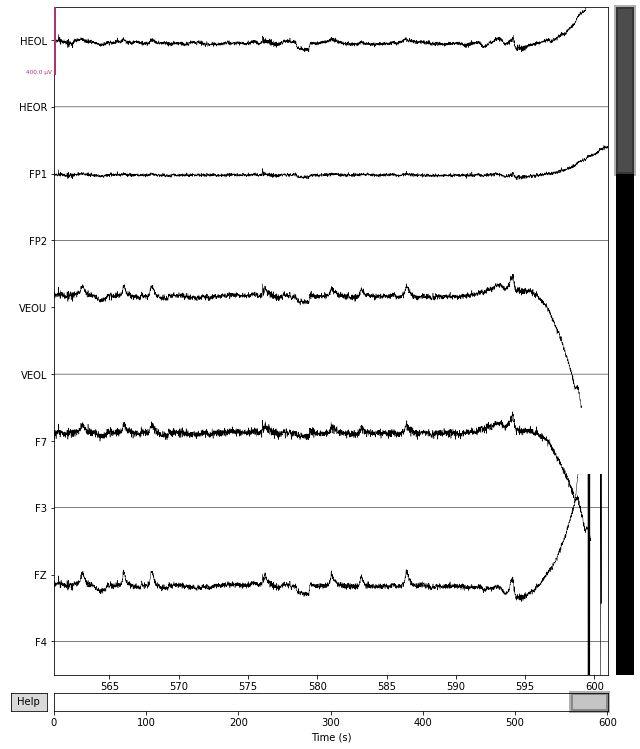

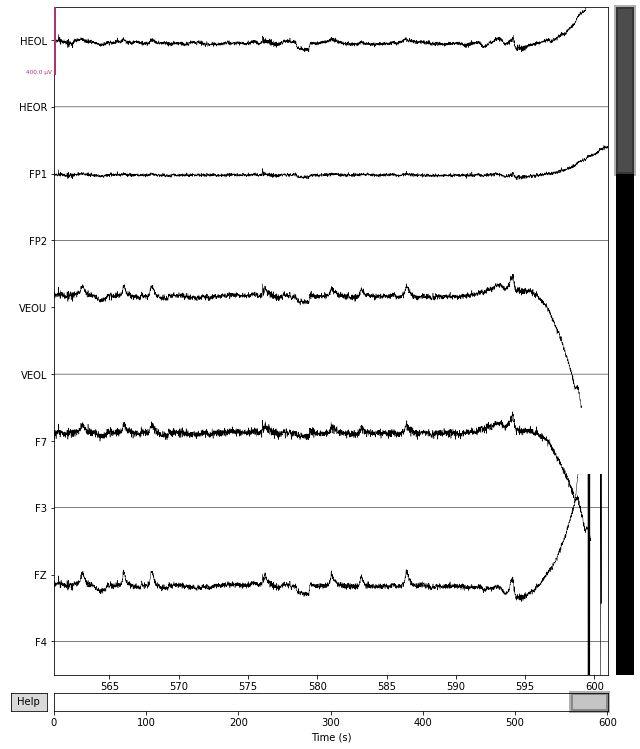

In [11]:
eeg.plot(start=total_seconds - last_n_seconds, duration=last_n_seconds, n_channels=10,scalings=dict(eeg=20e-5))

## Additional features (Power spectral density, mean, standard deviation of an epoch) and fixing the SE entropy

3 new features are added for each epoch: power spectral density, mean, standard deviation which provided more information for each epoch and therefore increasing the accuracy of each model.

Before, the spectral entropy produced a lot of NaN values. The cause is a bug in the Antropy library. The problem was that Antropy library caculated power spectral density and then applyed log function without checking if array contains value 0. If PSD for any frequency has the value of 0 the spectral entropy will be NaN. We fixed the problem by ditching the first element of the array where value 0 occurs the most (frequency range from 0 to 1). Numerical difference when ditching the first element is negligible.

Because of the improved results, this new and improved dataset will be used as a baseline for comparing other improvements.

In [6]:
print("Original")
print_report(Path(PATH_REPORT, "train-models-2021-12-09-19-17-19.txt"), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-07-15-46-01-fixeden-newfeat.txt"), "^===")

baseline_report = "train-models-2022-01-07-15-46-01-fixeden-newfeat.txt"

Original
=== Best model RandomForestClassifier with accuracy 0.9847222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9702777777777778 and parameters {'alpha': 0.0001, 'learning_rate': 'constant'}
=== Best model KNeighborsClassifier with accuracy 0.9613888888888888 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9772222222222222 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}


## Replace -inf, inf and NaN values with averages

As we fixed the entropy caculation, there are no more problematic values. Inf, -inf and NaN don't occur in the dataset anymore so replacement of values is not necessary.

Minimum value across the whole dataset is -0.0022
Maximum value across the whole dataset is 299
And there are no columns with NaN values

In [14]:
print_report(Path(PATH_REPORT, "checker-complete-raw-2022-01-08-14-53-50__brains=false__ica=false-2022-01-09-19-46-33.txt"), "^(Minimum|Maximum|Cols)")

Minimum values for columns [-0.0022840403503606604, ..., 4.2416617655392255]
Maximum values for columns [4.153868088207251e-18, ..., 299.0]
Cols with none Empty DataFrame


## ICA - Independent Component Analysis
What is ICA?
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#what-is-ica:
> Independent components analysis (ICA) is a technique for estimating independent source signals from a set of recordings in which the source signals were mixed together in unknown ratios. A common example of this is the problem of blind source separation: with 3 musical instruments playing in the same room, and 3 microphones recording the performance (each picking up all 3 instruments, but at varying levels), can you somehow “unmix” the signals recorded by the 3 microphones so that you end up with a separate “recording” isolating the sound of each instrument?

Filtering
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#filtering-to-remove-slow-drifts:
> Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. A high-pass filter with 1 Hz cutoff frequency is recommended.


Ctrl + F `use_ica` for code

ICA reconstruction process reduced the overall accuracy but it can be useful when doing dimensionality reduction

In [15]:
print("Original")
print_report(Path(PATH_REPORT, baseline_report), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-08-14-55-46-ica.txt"), "^===")

Original
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.9286111111111112 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.7763888888888889 and parameters {'alpha': 0.001, 'learning_rate': 'constant'}
=== Best model KNeighborsClassifier with accuracy 0.7963888888888888 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.8530555555555555 and parameters {'C': 500, 'gamma': 0.03125}


## Minmax scaler for each participant separately 

Instead of applying the minmax scaler to the whole dataset we decided to apply it to rows of each participant separately.

This method reduced the overall accuracy.

In [13]:
print("Original")
print_report(Path(PATH_REPORT, baseline_report), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-09-17-02-25-minmax-per-participant.txt"), "^===")

Original
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.9644444444444445 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.8991666666666667 and parameters {'alpha': 0.001, 'learning_rate': 'constant'}
=== Best model KNeighborsClassifier with accuracy 0.8594444444444445 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9516666666666668 and parameters {'C': 500, 'gamma': 0.03125}


## Alpha and beta brainwave decomposition

In this method, each signal is decomposed into 4 different signals:
- AL [8, 10] HZ
- AH [10, 12] HZ
- BL [13, 19] HZ
- BH [19, 25] HZ

Then, feature extraction is performed same as before on each of the 4 signals. The number of training features in the dataset increased by 4 times with this method.

This method reduced the overall accuracy.

Ctrl + F `use_brain` for code

In [17]:
print("Original")
print_report(Path(PATH_REPORT, baseline_report), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-09-13-22-20-brains-bandwaves.txt"), "^===")

Original
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.885 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.768888888888889 and parameters {'alpha': 0.05, 'learning_rate': 'constant'}
=== Best model KNeighborsClassifier with accuracy 0.7136111111111111 and parameters {'weights': 'uniform'}
=== Best model SVC with accuracy 0.7844444444444444 and parameters {'C': 1500, 'gamma': 0.001}


# Standard scaler instead of minmax scaler

Minmax scaler is very robust but standard scaler should explored if data is normally distributed. It's not known if data is normally, therefore the easiest thing to do is to check the accuracy of standard scaler. If standard scaler gives worse results it's because of the wrong assumption that features are normally distributed. Instead, the distribution of features might be skewed or fat tailed.

This method reduced the overall accuracy.

In [18]:
print("Original")
print_report(Path(PATH_REPORT, baseline_report), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-09-16-36-24-standardscaler.txt"), "^===")

Original
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.946111111111111 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.8952777777777777 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.8027777777777777 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.8769444444444445 and parameters {'C': 1500, 'gamma': 0.001}


## Re-referencing

In EEG data, the voltage for each electrode is recorded relative to other electrodes. The ‘reference’, which can be one or a combination of electrodes, is what the voltage will be relative to. This means that neural activity at the reference electrode will also be reflected in all the other electrodes, which could contaminate your signal.

This method increased the overall accuracy of every model except Radnom Forest. 

In [7]:
print("Original")
print_report(Path(PATH_REPORT, baseline_report), "^===")
print()
print("New")
print_report(Path(PATH_REPORT, "train-models-2022-01-10-01-50-17-rereference.txt"), "^===")

Original
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9755555555555555 and parameters {'alpha': 1e-05, 'learning_rate': 'adaptive'}
=== Best model KNeighborsClassifier with accuracy 0.9674999999999999 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9802777777777777 and parameters {'C': 100, 'gamma': 0.03125}

New
=== Best model RandomForestClassifier with accuracy 0.9872222222222222 and parameters {'max_features': 22, 'n_estimators': 500}
=== Best model MLPClassifier with accuracy 0.9769444444444444 and parameters {'alpha': 0.0001, 'learning_rate': 'constant'}
=== Best model KNeighborsClassifier with accuracy 0.9686111111111112 and parameters {'weights': 'distance'}
=== Best model SVC with accuracy 0.9824999999999999 and parameters {'C': 100, 'gamma': 0.03125}
